# -------------------------Flight delay Analysis and Prediction----------------------------

### Problem Statement::
The client wants predict flight delays based on the flight's details and predicted weather conditions which helps them to take the necessary corrective and preventive actions to improve business as well as service. 

### Data Description::
Every single flight is observed as per their scheduled departure and arrival timestamps, to record the details of trips made, traffic conditions, etc. Flight details like Origin, destination, date of flight, scheduled departure and scheduled arrival timestamps etc. Weather stations data details like station id along with it’s linked AirportID, ground height etc. Hourly aviation weather conditions data also provided for 2 years etc. 

### Objective::
To predict the delay in Flight and make suggestions to the business regarding features that have highest impact on the flight delays

### Importing Dependencies

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import datetime
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mp
from imblearn.over_sampling import SMOTE
from sklearn import tree
import pandas as pd # to import csv and for data manipulation
import matplotlib.pyplot as plt # to plot graph
import seaborn as sns # for intractve graphs
import numpy as np # for linear algebra
import datetime # to dela with date and time
from sklearn.preprocessing import StandardScaler # for preprocessing the data
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.tree import DecisionTreeClassifier # for Decision Tree classifier
from sklearn.svm import SVC # for SVM classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # to split the data
from sklearn.model_selection import GridSearchCV # for tunnig hyper parameter it will use all combination of given parameters
from sklearn.model_selection import RandomizedSearchCV # same for tunning hyper parameter but will use random combinations of parameters
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing

### Data understanding and data cleaning
This Involves - Exploring individual datasets, Handling missing/improper values, Extracting information from columns & dropping columns,Dummifying categorical variables & Mapping others.

#### Data is given in 4 parts. 
1. Flight Data - Has all the details about a flight like Flight number, origin, Destination, schedules arrival and departure time, etc 
2. Stations Data - Weather station ID, Airport ID and various parameters of Airport like station height, ground height, logitudea and latitude details, etc 
3. Hourly Data - Weather conditions likeVisibility, Wind Speed, Sky conditions and etc of months 1,3,5,7,9,11 
4. Hpd Data - Hourly Precipitation data for months 1,3,5,7,9,11

### Reading and exploring the data

In [2]:
os.chdir("")
train = pd.read_csv("")
print(train.shape)

os.chdir("")
StationsData = pd.read_csv('AllStationsData_PHD.txt',sep = "|")
print(StationsData.shape)

os.chdir("")
hourly1 = pd.read_csv('200401hourly.txt',sep = "," ,encoding = 'unicode_escape' )
hpd1 = pd.read_csv('200401hpd.txt',sep = ",",encoding = 'unicode_escape')
hourly3 = pd.read_csv('200403hourly.txt',sep = ",",encoding = 'unicode_escape')
hpd3 = pd.read_csv('200403hpd.txt',sep = ",",encoding = 'unicode_escape')
hourly5 = pd.read_csv('200405hourly.txt',sep = ",", encoding = 'unicode_escape')
hpd5 = pd.read_csv('200405hpd.txt',sep = ",",encoding = 'unicode_escape')
hourly7 = pd.read_csv('200407hourly.txt',sep = ",",encoding = 'unicode_escape')
hpd7 = pd.read_csv('200407hpd.txt',sep = ",",encoding = 'unicode_escape')
hourly9 = pd.read_csv('200409hourly.txt',sep = ",",encoding = 'unicode_escape')
hpd9 = pd.read_csv('200409hpd.txt',sep = ",",encoding = 'unicode_escape')
hourly11 = pd.read_csv('200411hourly.txt',sep = ",",encoding = 'unicode_escape')
hpd11 = pd.read_csv('200411hpd.txt',sep = ",",encoding = 'unicode_escape')

hourly = [hourly1,hourly3,hourly5,hourly7,hourly9,hourly11]
hpd = [hpd1,hpd3,hpd5,hpd7,hpd9,hpd11]

hourlyData = pd.concat(hourly)
print(hourlyData.shape)
hpdData = pd.concat(hpd)
print(hpdData.shape)

hourlyData = hourlyData.reset_index(drop =True)
hpdData = hpdData.reset_index(drop =True)

(7861, 12)
(1744, 8)
(6485177, 12)
(7697386, 4)


In [3]:
train.head()

,FlightNumber,Year,Month,DayofMonth,DayOfWeek,ScheduledDepTime,ScheduledArrTime,ScheduledTravelTime,Origin,Destination,Distance,ActualArrivalTimeStamp
0,BOS_CLE_29089,2004,9,20,1,1000,1154,114,BOS,CLE,563,20/09/04 11:54
1,CLE_ATL_44346,2004,11,19,5,1440,1634,114,CLE,ATL,554,19/11/04 18:55
2,SNA_LAS_44378,2004,5,4,2,1800,1902,62,SNA,LAS,226,04/05/04 19:02
3,CLT_TPA_51502,2004,7,6,2,1400,1533,93,CLT,TPA,508,06/07/04 15:33
4,MSP_ORD_44884,2004,9,23,4,830,946,76,MSP,ORD,334,23/09/04 09:46


#### Creating a new features 'ScheduledArrTimeStamp' and 'Time_diff' to find delay time and derive the target variable 'FlightDelayStatus'. A Flight is considered delayed if the difference between Scheduled arrival time and actual arrival time > 15min.

In [4]:
train.ScheduledArrTime = train.ScheduledArrTime.astype("str")
train.ScheduledArrTime = train.ScheduledArrTime.str.zfill(4)
train['ScheduledArrHr'] = train['ScheduledArrTime'].str[:2]
train['ScheduledArrMin'] = train['ScheduledArrTime'].str[-2:]
train.ScheduledArrHr = train.ScheduledArrHr.astype("int64")
train.ScheduledArrMin = train.ScheduledArrMin.astype("int64")
train['ScheduledArrTimeStamp'] = pd.to_datetime(train[['Year', 'Month', 'DayofMonth','ScheduledArrHr','ScheduledArrMin']].rename(columns={'Year': 'year', 'Month':'month', 'DayofMonth': 'day','ScheduledArrHr': 'hour', 'ScheduledArrMin': 'minute'}))

In [5]:
train['ActualArrivalTimeStamp'] = pd.to_datetime(train['ActualArrivalTimeStamp'],format='%d/%m/%y %H:%M')

In [6]:
train['Time_diff'] = ((train['ActualArrivalTimeStamp'] - train['ScheduledArrTimeStamp'] ).dt.seconds)/60
Time_diff = ((train['ActualArrivalTimeStamp'] - train['ScheduledArrTimeStamp'] ).dt.seconds)/60

In [7]:
train['FlightDelayStatus'] = 0
for i in range(0,len(train)):
    if  Time_diff[i] > 15 :
        train['FlightDelayStatus'][i]  = 1
    else :
        train['FlightDelayStatus'][i]  = 2

In [8]:
train.to_csv('asd.csv')

#### If FlightDelayStatus is 1 the Flight is Delayed and If FlightDelayStatus is 2 the Flight is not Delayed

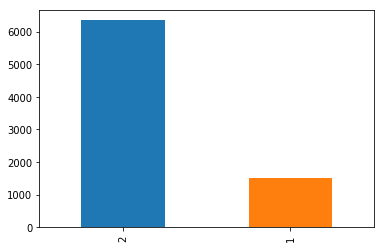

In [9]:
train['FlightDelayStatus'].value_counts().plot.bar()

In [11]:
print(StationsData.shape)
StationsData.head()

(1744, 8)


,WeatherStationID,AirportID,GroundHeight,StationHeight,BarometerHeight,Latitude,Longitude,TimeZone
0,3011,TEX,0,0,0,37.57,-107.55,+7
1,3012,SKX,0,0,0,36.28,-105.40,+7
2,3013,LAA,3683,3703,3675,38.04,-102.41,+7
3,3014,4SL,0,6909,0,35.47,-107.14,+7
4,3016,RIL,5503,5544,5506,39.32,-107.44,+7


#### Merging Flight Data with Stations Data

In [12]:
DataV0 = pd.merge(train, StationsData, left_on=['Destination'], right_on=['AirportID'])
DataV0 = DataV0.drop(["AirportID"], axis = 1)

In [13]:
DataV0.isnull().sum()

FlightNumber              0
Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
ScheduledDepTime          0
ScheduledArrTime          0
ScheduledTravelTime       0
Origin                    0
Destination               0
Distance                  0
ActualArrivalTimeStamp    0
ScheduledArrHr            0
ScheduledArrMin           0
ScheduledArrTimeStamp     0
Time_diff                 0
FlightDelayStatus         0
WeatherStationID          0
GroundHeight              0
StationHeight             0
BarometerHeight           0
Latitude                  0
Longitude                 0
TimeZone                  0
dtype: int64

#### Creating new features 'YearMonthDay','HourlyHr' in DataV0 and HourlyData resectively to match common columns 'WeatherStationID','YearMonthDay',hour in both data frames

In [14]:
DataV0['YearMonthDay'] = DataV0.ScheduledArrTimeStamp.dt.date
DataV0['YearMonthDay'] = DataV0['YearMonthDay'].astype(str)
DataV0['YearMonthDay'] = DataV0['YearMonthDay'].str.replace("-","")
DataV0['YearMonthDay'] = DataV0.YearMonthDay.astype("int64")

In [15]:
hourlyData.Time = hourlyData.Time.astype("str")
hourlyData['Time'] = hourlyData['Time'].str.zfill(4)
hourlyData['HourlyHr'] = hourlyData['Time'].str[:2]
hourlyData['HourlyMin'] = hourlyData['Time'].str[-2:]
hourlyData['Time'] = hourlyData.HourlyHr + ":" + hourlyData.HourlyMin
hourlyData.HourlyHr = hourlyData.HourlyHr.astype("int64")
hourlyData.HourlyMin = hourlyData.HourlyMin.astype("int64")

In [16]:
hourlyData.YearMonthDay = hourlyData.YearMonthDay.astype(str)
hourlyData['YearMonthDay'] = hourlyData['YearMonthDay'].str.replace("2004051µ","20040510")
hourlyData.YearMonthDay = hourlyData.YearMonthDay.astype("int64")

In [17]:
DataV1 = pd.merge( DataV0, hourlyData, how='left', left_on=['WeatherStationID','YearMonthDay','ScheduledArrHr'], right_on=['WeatherStationID','YearMonthDay','HourlyHr'])

In [18]:
print(DataV1.shape)
DataV1.head()

(9425, 37)


,FlightNumber,Year,Month,DayofMonth,DayOfWeek,ScheduledDepTime,ScheduledArrTime,ScheduledTravelTime,Origin,Destination,...,Visibility,DBT,DewPointTemp,RelativeHumidityPercent,WindSpeed,WindDirection,WindGustValue,StationPressure,HourlyHr,HourlyMin
0,BOS_CLE_29089,2004,9,20,1,1000,1154,114,BOS,CLE,...,10SM,71.0,35.0,27.0,8,190,0.0,29.49,11.0,51.0
1,FLL_CLE_45262,2004,3,13,6,1600,1847,167,FLL,CLE,...,10SM,29.0,23.0,78.0,0,000,0.0,29.56,18.0,51.0
2,EWR_CLE_37064,2004,3,4,4,645,0828,103,EWR,CLE,...,1.25SM,45.0,44.0,97.0,4,210,0.0,29.33,8.0,51.0
3,IAD_CLE_47407,2004,9,13,1,745,0900,75,IAD,CLE,...,10SM,76.0,57.0,52.0,5,180,0.0,29.39,9.0,51.0
4,STL_CLE_54043,2004,11,7,7,1200,1433,93,STL,CLE,...,10SM,58.0,40.0,51.0,11,310,0.0,29.01,14.0,51.0


#### Similarly, creating new features from HpdData to merge and form the final DataFrame

In [19]:
hpdData.Time = hpdData.Time.astype("str")
hpdData['Time'] = hpdData['Time'].str.zfill(4)
hpdData['Hr'] = hpdData['Time'].str[:2]
hpdData.Hr = hpdData.Hr.astype("int64")

In [20]:
DataV2 = pd.merge( DataV1, hpdData, how='left', left_on=['WeatherStationID','YearMonthDay','ScheduledArrHr'], right_on=['WeatherStationID','YearMonthDay','Hr'])

In [21]:
print(DataV2.shape)
DataV2.head()

(9449, 40)


,FlightNumber,Year,Month,DayofMonth,DayOfWeek,ScheduledDepTime,ScheduledArrTime,ScheduledTravelTime,Origin,Destination,...,RelativeHumidityPercent,WindSpeed,WindDirection,WindGustValue,StationPressure,HourlyHr,HourlyMin,Time_y,HourlyPrecip,Hr
0,BOS_CLE_29089,2004,9,20,1,1000,1154,114,BOS,CLE,...,27.0,8,190,0.0,29.49,11.0,51.0,1151,0.0,11.0
1,FLL_CLE_45262,2004,3,13,6,1600,1847,167,FLL,CLE,...,78.0,0,000,0.0,29.56,18.0,51.0,1851,0.0,18.0
2,EWR_CLE_37064,2004,3,4,4,645,0828,103,EWR,CLE,...,97.0,4,210,0.0,29.33,8.0,51.0,0851,0.0,8.0
3,IAD_CLE_47407,2004,9,13,1,745,0900,75,IAD,CLE,...,52.0,5,180,0.0,29.39,9.0,51.0,0951,0.0,9.0
4,STL_CLE_54043,2004,11,7,7,1200,1433,93,STL,CLE,...,51.0,11,310,0.0,29.01,14.0,51.0,1451,0.0,14.0


#### Since merged based on Hour multiple duplicate instances for each flight have been created. Therefore, removing all other instances except the one with minimum time difference between hourlyTimeStamp and ScheduledArrTimeStamp.


In [22]:
DataV2['HourlyHr'].fillna(value=DataV2['HourlyHr'].mean(),inplace =True)
DataV2['HourlyMin'].fillna(value=DataV2['HourlyMin'].mean(),inplace =True)
DataV2['hourlyTimeStamp'] = pd.to_datetime(DataV2[['Year', 'Month', 'DayofMonth','HourlyHr','HourlyMin']].rename(columns={'Year': 'year', 'Month':'month', 'DayofMonth': 'day', 'HourlyHr': 'hour', 'HourlyMin': 'minute'}))

In [23]:
DataV3 = DataV2.iloc[0:0]
temp = DataV2.iloc[0:0]
for i in range(0,7861):
    if DataV2.FlightNumber.value_counts()[i] > 1:
        temp = DataV2[DataV2['FlightNumber'] == DataV2.FlightNumber.value_counts().index[i]]
        s = np.argmin(temp.ScheduledArrTimeStamp - temp.hourlyTimeStamp)
        DataV3 = DataV3.append(DataV2.loc[[s]])
    else:
        DataV3 = DataV3.append(DataV2[DataV2['FlightNumber'] == DataV2.FlightNumber.value_counts().index[i]])

In [24]:
print(DataV3.FlightNumber.nunique())
print(DataV3.shape)
DataV3 = DataV3.reset_index(drop =True)
DataV3.head()

7861
(7861, 41)


,FlightNumber,Year,Month,DayofMonth,DayOfWeek,ScheduledDepTime,ScheduledArrTime,ScheduledTravelTime,Origin,Destination,...,WindSpeed,WindDirection,WindGustValue,StationPressure,HourlyHr,HourlyMin,Time_y,HourlyPrecip,Hr,hourlyTimeStamp
0,LEX_ATL_28655,2004,11,24,3,925,1045,80,LEX,ATL,...,13,300,0.0,28.72,10.0,51.0,1051,0.54,10.0,2004-11-24 10:51:00
1,SLC_SGU_30093,2004,5,17,1,750,0907,77,SLC,SGU,...,8,200,0.0,29.84,9.0,55.0,0915,0.00,9.0,2004-05-17 09:55:00
2,LBB_DFW_47885,2004,5,27,4,1610,1715,65,LBB,DFW,...,8,050,0.0,29.10,17.0,53.0,1753,1.06,17.0,2004-05-27 17:53:00
3,ATL_GTR_26690,2004,5,18,2,1734,1753,79,ATL,GTR,...,3,250,0.0,30.16,17.0,55.0,1715,0.00,17.0,2004-05-18 17:55:00
4,DFW_ILE_34698,2004,5,14,5,839,0942,63,DFW,ILE,...,11,340,18.0,30.18,9.0,55.0,0915,0.00,9.0,2004-05-14 09:55:00


#### Visibility column is given along with the units SM. Removing the units. Generally, if the wind speed is less than 6 knots wind direction is coded as VRB. Making an assumption that < than 6 knots is neglible speed with no direction

In [25]:
DataV3.Visibility = DataV3.Visibility.astype(str)
DataV3.Visibility = DataV3.Visibility.str.replace("SM", "")
DataV3.WindDirection = DataV3.WindDirection.astype(str)
DataV3.WindDirection = DataV3['WindDirection'].str.replace("VRB","000")

#### Imputing the missing values

In [26]:
DataV3['WindSpeed'].fillna(value=DataV3['WindSpeed'].value_counts().index[0],inplace =True)
DataV3['WindDirection'].fillna(value=DataV3['WindDirection'].value_counts().index[0],inplace =True)
DataV3['SkyConditions'].fillna(value=DataV3['SkyConditions'].value_counts().index[0],inplace =True)

####  Contraction Meaning Summation    Amount of Layer
-  VV          Vertical Visibility  8/8
-  SKC or CLR  Clear                0 
-  FEW         Few                  1/8 - 2/8
-  SCT         Scattered            3/8 - 4/8
-  BKN         Broken               5/8 - 7/8
-  OVC         Overcast             8/8

-  When no layers at or below 12,000 feet are reported CLR is used.
-  If cloud layer is between (1/8)*12000 to (2/8)*12000 feet FEW contraction is used. LL'ly others.

In [27]:
DataV3['SkyConditions'].value_counts()

CLR                            1094
FEW250                          252
SCT250                          136
BKN250                          118
FEW200                           72
FEW060                           46
FEW120                           40
FEW050                           39
FEW040                           35
OVC005                           33
OVC007                           32
FEW055                           31
OVC006                           31
FEW050 SCT250                    30
FEW300                           29
OVC004                           28
FEW045                           28
OVC003                           27
FEW150                           27
FEW035                           27
FEW030                           26
SCT060                           25
SCT050                           25
SCT055                           24
FEW060 SCT250                    24
FEW100                           22
OVC008                           22
FEW010                      

#### Sky condition is coded in the format, NNNhhh, where NNN is the sky cover and hhh is the height of the layer. Cleaning the SkyConditions column and deriving new features SkyCover and LayerHt.

In [28]:
a = DataV3['SkyConditions'].str.replace('\d+', '')
g1 = a.str[-3:]
n = DataV3['SkyConditions'].str.replace('[^0-9]', '')
n= n.astype(str)
n =n.str[-3:]
for i in range(0,7861):
    if(len(n[i]) ==0):
        n[i]='0'

In [29]:
DataV3['SkyCover'] = g1
DataV3['LayerHt'] = n

In [30]:
tcu = DataV3[DataV3.SkyCover == 'TCU'].SkyConditions.str.replace('\d+', '').str[:3]
for i in (tcu.index):
    if DataV3.SkyCover[i] == 'TCU' :
        DataV3.SkyCover[i] = tcu[i]
CCB = DataV3[DataV3.SkyCover == 'CCB'].SkyConditions.str.replace('\d+', '').str[:3]
for i in (CCB.index):
    if DataV3.SkyCover[i] == 'CCB' :
        DataV3.SkyCover[i] = CCB[i]
BK = DataV3[DataV3.SkyCover == ' BK'].SkyConditions.str.replace('\d+', '').str[4:8]
for i in (BK.index):
    if DataV3.SkyCover[i] == ' BK' :
        DataV3.SkyCover[i] = 'BKN'       
OV = DataV3[DataV3.SkyCover == ' OV'].SkyConditions.str.replace('\d+', '').str[4:8]
for i in (OV.index):
    if DataV3.SkyCover[i] == ' OV' :
        DataV3.SkyCover[i] = 'OVC'
NCB = DataV3[DataV3.SkyCover == 'NCB'].SkyConditions.str.replace('\d+', '')
for i in (NCB.index):
    if DataV3.SkyCover[i] == 'NCB' :
        DataV3.SkyCover[i] = 'BKN'
WCB = DataV3[DataV3.SkyCover == 'WCB'].SkyConditions.str.replace('\d+', '').str[:3]
for i in (WCB.index):
    if DataV3.SkyCover[i] == 'WCB' :
        DataV3.SkyCover[i] = WCB[i]
TCB = DataV3[DataV3.SkyCover == 'TCB'].SkyConditions.str.replace('\d+', '').str[:3]
for i in (TCB.index):
    if DataV3.SkyCover[i] == 'TCB' :
        DataV3.SkyCover[i] = TCB[i]
#since the ft is ranging from 100ft to 900ft falls under few category
VV = DataV3[DataV3.SkyCover == 'VV'].SkyConditions.str.replace('\d+', '').str[:3]
for i in (VV.index):
    if DataV3.SkyCover[i] == 'VV' :
        DataV3.SkyCover[i] = 'FEW'

In [31]:
DataV3.SkyCover.value_counts()

BKN    2113
OVC    1989
SCT    1583
CLR    1094
FEW    1082
Name: SkyCover, dtype: int64

In [32]:
DataV3['WindDirection'] = DataV3['WindDirection'].str.replace("nan","000")
DataV3['WindDirection'] = DataV3['WindDirection'].astype('int64')

#### Creating new feature WindCompDir based on wind Directions

In [33]:
arr=["N","NNE","NE","ENE","E","ESE", "SE", "SSE","S","SSW","SW","WSW","W","WNW","NW","NNW"]    
DataV3['WindCompDir'] = ''
for i in range(0, len(DataV3)):
    num = DataV3.WindDirection[i]
    val=int((num/22.5)+.5)
    DataV3['WindCompDir'][i] = arr[(val % 16)]

In [34]:
DataV3.WindCompDir = DataV3.WindCompDir.astype('category')

In [35]:
print(DataV3.WindCompDir.value_counts())

N      1479
S       826
W       563
SSE     482
E       479
SSW     474
WSW     442
SW      432
WNW     384
NW      366
ENE     350
SE      347
NNW     319
NNE     312
NE      311
ESE     295
Name: WindCompDir, dtype: int64


#### Checking for NULL values and imputing them with either mean or mode according to datatype.

In [36]:
print(DataV3.shape)
nul =   DataV3.isnull().sum()
nul[nul>0]

(7861, 44)


Time_x                      90
DBT                        174
DewPointTemp               175
RelativeHumidityPercent    178
WindGustValue               92
StationPressure            172
Time_y                      22
HourlyPrecip               477
Hr                          22
dtype: int64

In [84]:
DataV3['DBT'].fillna(value=DataV3['DBT'].mean(),inplace =True)
DataV3['DewPointTemp'].fillna(value=DataV3['DewPointTemp'].mean(),inplace =True)
DataV3['Visibility'].fillna(value=DataV3['Visibility'].value_counts().index[0],inplace =True)
DataV3['RelativeHumidityPercent'].fillna(value=DataV3['RelativeHumidityPercent'].mean(),inplace =True)
DataV3['WindGustValue'].fillna(value=DataV3['WindGustValue'].mean(),inplace =True)
DataV3['StationPressure'].fillna(value=DataV3['StationPressure'].mean(),inplace =True)
DataV3['HourlyPrecip'].fillna(value=DataV3['HourlyPrecip'].mean(),inplace =True)

In [38]:
DataV3["DayOfWeek"] = DataV3["DayOfWeek"].astype('category')
DataV3['WindSpeed'] = DataV3['WindSpeed'].astype('int64')
DataV3['Visibility'] = DataV3['Visibility'].astype('float64')
DataV3["SkyConditions"] = DataV3["SkyConditions"].astype('category')
DataV3["TimeZone"] = DataV3["TimeZone"].astype('category')
DataV3["FlightDelayStatus"] = DataV3["FlightDelayStatus"].astype('category')

In [39]:
DataV3["SkyCover"] = DataV3["SkyCover"].astype('category')
DataV3['LayerHt'] = DataV3['LayerHt'].astype('int64')
DataV3['Visibility'].fillna(value=DataV3['Visibility'].value_counts().index[0],inplace =True)

In [88]:
ull = DataV3.isnull().sum()
ull[ull>0]

Time_x    90
Time_y    22
Hr        22
dtype: int64

In [41]:
DataV3.to_csv('Flight.csv', index= False)

### Correlations Heatmap

In [253]:
correlations = DataV3[['Year', 'Month', 'DayofMonth',
       'ScheduledDepTime', 'ScheduledArrTime', 'ScheduledTravelTime', 'Distance', 'ScheduledArrHr',
       'ScheduledArrMin', 'WeatherStationID', 'GroundHeight', 'StationHeight', 'BarometerHeight',
       'Latitude', 'Longitude', 'YearMonthDay',
       'Visibility', 'DBT', 'DewPointTemp', 'RelativeHumidityPercent',
       'WindSpeed', 'WindGustValue', 'StationPressure',
       'HourlyPrecip']]

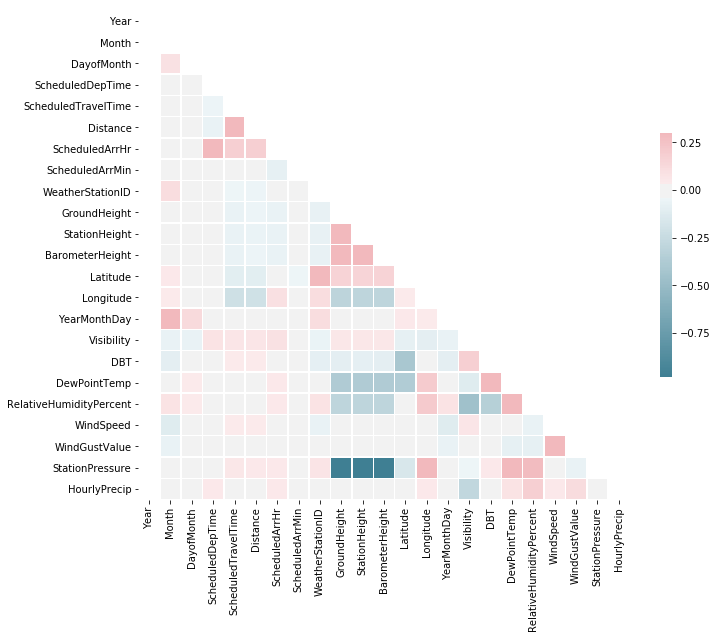

In [254]:
# Compute the correlation matrix
corr = correlations.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220,10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
             linewidths=.5, cbar_kws={"shrink": .5},)

### Observations:: 
#### Pressure decreases with increasing altitude, since there is a relation between pressure and height, the three columns Ground Height, Station Height, BarometerHeight are correlated with Station Pressure

#### Creating the Final DataFrame and removing unneccesary columns for model building

In [45]:
DataV4 = DataV3.drop(["FlightNumber","Year","Month","DayofMonth",'ScheduledTravelTime',"ScheduledArrHr","ScheduledArrMin","ScheduledDepTime","ScheduledArrTime","Origin","Destination","WeatherStationID","ActualArrivalTimeStamp","Time_diff","YearMonthDay","HourlyHr","HourlyMin","SkyConditions","ScheduledArrTimeStamp","hourlyTimeStamp","TimeZone",'Hr','Time_y','Time_x','WindDirection'], axis = 1)

In [89]:
DataV4.describe()

,Distance,GroundHeight,StationHeight,BarometerHeight,Latitude,Longitude,Visibility,DBT,DewPointTemp,RelativeHumidityPercent,WindSpeed,WindGustValue,StationPressure,HourlyPrecip,LayerHt
count,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000,7861.000000
mean,743.764025,834.865920,843.882076,840.098461,36.687598,-92.156701,9.054168,68.984910,52.770622,61.124821,8.265615,2.750547,29.148807,0.008043,119.286096
std,522.629372,1202.390869,1212.530498,1199.485756,5.290329,16.075175,2.168905,14.875156,15.084919,21.010682,4.623749,7.360462,1.219157,0.055255,101.723647
min,69.000000,0.000000,0.000000,0.000000,18.200000,-162.360000,0.000000,-21.000000,-27.000000,4.000000,0.000000,0.000000,23.690000,0.000000,0.000000
25%,368.000000,87.000000,65.000000,98.000000,33.380000,-100.290000,10.000000,60.000000,43.000000,47.000000,5.000000,0.000000,29.050000,0.000000,25.000000
50%,595.000000,559.000000,596.000000,562.000000,37.370000,-87.450000,10.000000,71.000000,56.000000,61.124821,8.000000,0.000000,29.420000,0.000000,90.000000
75%,951.000000,901.000000,899.000000,904.000000,40.470000,-81.040000,10.000000,80.000000,65.000000,77.000000,11.000000,0.000000,29.860000,0.000000,250.000000
max,4962.000000,6180.000000,6535.000000,6183.000000,71.170000,-64.580000,10.000000,108.000000,79.000000,100.000000,34.000000,50.000000,30.850000,1.780000,601.000000


### Performing the same preprocessing on Test data as Train Data

In [46]:
os.chdir("")
test = pd.read_csv("FlightDelay_Test.csv")
print(test.shape)

os.chdir("")
Thourly3 = pd.read_csv('200503hourly.txt',sep = ",",encoding = 'unicode_escape')
Thpd3 = pd.read_csv('200503hpd.txt',sep = ",",encoding = 'unicode_escape')
Thourly7 = pd.read_csv('200507hourly.txt',sep = ",",encoding = 'unicode_escape')
Thpd7 = pd.read_csv('200507hpd.txt',sep = ",",encoding = 'unicode_escape')
Thourly9 = pd.read_csv('200509hourly.txt',sep = ",",encoding = 'unicode_escape')
Thpd9 = pd.read_csv('200509hpd.txt',sep = ",",encoding = 'unicode_escape')
Thourly11 = pd.read_csv('200511hourly.txt',sep = ",",encoding = 'unicode_escape')
Thpd11 = pd.read_csv('200511hpd.txt',sep = ",",encoding = 'unicode_escape')

Thourly = [Thourly3,Thourly7,Thourly9,Thourly11]
Thpd = [Thpd3,Thpd7,Thpd9,Thpd11]

hourlyTestData = pd.concat(Thourly)
print(hourlyTestData.shape)
hpdTestData = pd.concat(Thpd)
print(hpdTestData.shape)

hourlyTestData = hourlyTestData.reset_index(drop =True)
hpdTestData = hpdTestData.reset_index(drop =True)

(6566, 11)
(5031729, 12)
(4410021, 4)


In [47]:
test.ScheduledArrTime = test.ScheduledArrTime.astype("str")
test.ScheduledArrTime = test.ScheduledArrTime.str.zfill(4)
test['ScheduledArrHr'] = test['ScheduledArrTime'].str[:2]
test['ScheduledArrMin'] = test['ScheduledArrTime'].str[-2:]
test.ScheduledArrHr = test.ScheduledArrHr.astype("int64")
test.ScheduledArrMin = test.ScheduledArrMin.astype("int64")

In [48]:
TestV0 = pd.merge(test, StationsData, how='left', left_on=['Destination'], right_on=['AirportID'])
TestV0 = TestV0.drop(["AirportID"], axis = 1)

In [49]:
TestV0['ScheduledArrTimeStamp'] = pd.to_datetime(TestV0[['Year', 'Month', 'DayofMonth','ScheduledArrHr','ScheduledArrMin']].rename(columns={'Year': 'year', 'Month':'month', 'DayofMonth': 'day','ScheduledArrHr': 'hour', 'ScheduledArrMin': 'minute'}))
TestV0['YearMonthDay'] = TestV0.ScheduledArrTimeStamp.dt.date
TestV0['YearMonthDay'] = TestV0['YearMonthDay'].astype(str)
TestV0['YearMonthDay'] = TestV0['YearMonthDay'].str.replace("-","")
TestV0['YearMonthDay'] = TestV0.YearMonthDay.astype("int64")

In [50]:
hourlyTestData.Time = hourlyTestData.Time.astype("str")
hourlyTestData['Time'] = hourlyTestData['Time'].str.zfill(4)
hourlyTestData['HourlyHr'] = hourlyTestData['Time'].str[:2]
hourlyTestData['HourlyMin'] = hourlyTestData['Time'].str[-2:]
hourlyTestData['Time'] = hourlyTestData.HourlyHr + ":" + hourlyTestData.HourlyMin
hourlyTestData.HourlyHr = hourlyTestData.HourlyHr.astype("int64")
hourlyTestData.HourlyMin = hourlyTestData.HourlyMin.astype("int64")

In [51]:
TestV1 =pd.merge( TestV0, hourlyTestData, how='left', left_on=['WeatherStationID','YearMonthDay','ScheduledArrHr'], right_on=['WeatherStationID','YearMonthDay','HourlyHr'])

In [52]:
hpdTestData.Time = hpdTestData.Time.astype("str")
hpdTestData['Time'] = hpdTestData['Time'].str.zfill(4)
hpdTestData['Hr'] = hpdTestData['Time'].str[:2]
hpdTestData.Hr = hpdTestData.Hr.astype("int64")

In [53]:
TestV2 = pd.merge( TestV1, hpdTestData, how='left', left_on=['WeatherStationID','YearMonthDay','ScheduledArrHr'], right_on=['WeatherStationID','YearMonthDay','Hr'])

In [54]:
TestV2.shape

(7642, 37)

In [55]:
TestV2['HourlyHr'].fillna(value=TestV2['HourlyHr'].mean(),inplace =True)
TestV2['HourlyMin'].fillna(value=TestV2['HourlyMin'].mean(),inplace =True)
TestV2['hourlyTimeStamp'] = pd.to_datetime(TestV2[['Year', 'Month', 'DayofMonth','HourlyHr','HourlyMin']].rename(columns={'Year': 'year', 'Month':'month', 'DayofMonth': 'day', 'HourlyHr': 'hour', 'HourlyMin': 'minute'}))

In [56]:
TestV3 = TestV2.iloc[0:0]
temp = TestV2.iloc[0:0]
for i in range(0,6566):
    if TestV2.FlightNumber.value_counts()[i] > 1:
        temp = TestV2[TestV2['FlightNumber'] == TestV2.FlightNumber.value_counts().index[i]]
        s = np.argmin(temp.ScheduledArrTimeStamp - temp.hourlyTimeStamp)
        TestV3 = TestV3.append(TestV2.loc[[s]])
    else:
        TestV3 = TestV3.append(TestV2[TestV2['FlightNumber'] == TestV2.FlightNumber.value_counts().index[i]])

In [57]:
print(TestV3.shape)
print(TestV3.FlightNumber.value_counts().sum())
TestV3.head()

(6566, 38)
6566


,FlightNumber,Year,Month,DayofMonth,DayOfWeek,ScheduledDepTime,ScheduledArrTime,ScheduledTravelTime,Origin,Destination,...,WindSpeed,WindDirection,WindGustValue,StationPressure,HourlyHr,HourlyMin,Time_y,HourlyPrecip,Hr,hourlyTimeStamp
3901,PHX_IAD_63923,2005,3,28,1,1002,1620,258,PHX,IAD,...,0,000,0.0,28.97,16.0,51.0,1651,0.16,16.0,2005-03-28 16:51:00
5358,DEN_MTJ_84048,2005,3,29,2,853,0959,66,DEN,MTJ,...,9,260,0.0,NaN,9.0,57.0,0953,NaN,9.0,2005-03-29 09:57:00
2421,IAD_ATL_81047,2005,7,6,3,1735,1938,123,IAD,ATL,...,14,060,23.0,NaN,19.0,57.0,1951,3.58,19.0,2005-07-06 19:57:00
1710,BDL_ATL_59903,2005,3,22,2,1147,1425,158,BDL,ATL,...,13,030,0.0,NaN,14.0,58.0,1451,0.43,14.0,2005-03-22 14:58:00
429,PHL_MCO_80370,2005,3,25,5,1505,1740,155,PHL,MCO,...,10,320,0.0,29.83,17.0,53.0,1753,1.05,17.0,2005-03-25 17:53:00


In [58]:
tes = pd.DataFrame(TestV0.FlightNumber)
TestV4 = pd.merge( tes, TestV3, how='left', on=['FlightNumber'])

In [59]:
TestV4['SkyConditions'].fillna(value=TestV4['SkyConditions'].value_counts().index[0],inplace =True)

In [60]:
ta = TestV4['SkyConditions'].str.replace('\d+', '')
tg1 = ta.str[-3:]
tn = TestV4['SkyConditions'].str.replace('[^0-9]', '')
tn = tn.astype(str)
tn = tn.str[-3:]

In [61]:
for i in range(0,6566):
    if(len(tn[i]) ==0):
        tn[i]='0'

In [62]:
TestV4['SkyCover'] = tg1
TestV4['LayerHt'] = tn

In [63]:
tcu = TestV4[TestV4.SkyCover == 'TCU'].SkyConditions.str.replace('\d+', '').str[:3]
for i in (tcu.index):
    if TestV4.SkyCover[i] == 'TCU' :
        TestV4.SkyCover[i] = tcu[i]
CCB = TestV4[TestV4.SkyCover == 'CCB'].SkyConditions.str.replace('\d+', '').str[:3]
for i in (CCB.index):
    if TestV4.SkyCover[i] == 'CCB' :
        TestV4.SkyCover[i] = CCB[i]
BK = TestV4[TestV4.SkyCover == ' BK'].SkyConditions.str.replace('\d+', '')
for i in (BK.index):
    if TestV4.SkyCover[i] == ' BK' :
        TestV4.SkyCover[i] = 'BKN'
Ov = TestV4[TestV4.SkyCover == ' OV'].SkyConditions.str.replace('\d+', '')
for i in (Ov.index):
    if TestV4.SkyCover[i] == ' OV' :
        TestV4.SkyCover[i] = 'BKN'
NCb = TestV4[TestV4.SkyCover == 'NCB'].SkyConditions.str.replace('\d+', '')
for i in (NCb.index):
    if TestV4.SkyCover[i] == 'NCB' :
        TestV4.SkyCover[i] = 'BKN'
WCb = TestV4[TestV4.SkyCover == 'WCB'].SkyConditions.str.replace('\d+', '').str[:3]
for i in (WCb.index):
    if TestV4.SkyCover[i] == 'WCB' :
        TestV4.SkyCover[i] = WCb[i]
TCb = TestV4[TestV4.SkyCover == 'TCB'].SkyConditions.str.replace('\d+', '').str[:3]
for i in (TCb.index):
    if TestV4.SkyCover[i] == 'TCB' :
        TestV4.SkyCover[i] = TCb[i]
Vv = TestV4[TestV4.SkyCover == 'VV'].SkyConditions.str.replace('\d+', '').str[:3]
for i in (Vv.index):
    if TestV4.SkyCover[i] == 'VV' :
        TestV4.SkyCover[i] = 'FEW'

In [64]:
TestV4.SkyCover.value_counts()

BKN    1725
OVC    1497
SCT    1305
CLR    1024
FEW    1015
Name: SkyCover, dtype: int64

In [65]:
TestV4.WindDirection = TestV4.WindDirection.astype(str)
TestV4.WindDirection = TestV4['WindDirection'].str.replace("VRB","000")
TestV4['WindDirection'].fillna(value=TestV4['WindDirection'].value_counts().index[0],inplace =True)
TestV4['WindDirection'] = TestV4['WindDirection'].str.replace("nan","000")
TestV4['WindDirection'] = TestV4['WindDirection'].astype('int64')

In [66]:
TestV4['WindCompDir'] = ''
for i in range(0, len(TestV4)):
    num = TestV4.WindDirection[i]
    val=int((num/22.5)+.5)
    TestV4['WindCompDir'][i] = arr[(val % 16)]

In [67]:
print(TestV4.shape)
nul = TestV4.isnull().sum()
nul[nul>0]

(6566, 41)


Time_x                      11
Visibility                  12
DBT                         74
DewPointTemp                74
RelativeHumidityPercent     76
WindSpeed                   13
WindGustValue               13
StationPressure             65
Time_y                       7
HourlyPrecip               389
Hr                           7
dtype: int64

In [68]:
TestV4.Visibility = TestV4.Visibility.astype(str)
TestV4.Visibility = TestV4.Visibility.str.replace("SM", "")

In [69]:
TestV4['WindSpeed'].fillna(value=TestV4['WindSpeed'].value_counts().index[0],inplace =True)
TestV4['WindDirection'].fillna(value=TestV4['WindDirection'].value_counts().index[0],inplace =True)
TestV4['DBT'].fillna(value=TestV4['DBT'].mean(),inplace =True)
TestV4['Visibility'].fillna(value=TestV4['Visibility'].value_counts().index[0],inplace =True)
TestV4['DewPointTemp'].fillna(value=TestV4['DewPointTemp'].mean(),inplace =True)
TestV4['RelativeHumidityPercent'].fillna(value=TestV4['RelativeHumidityPercent'].mean(),inplace =True)
TestV4['WindGustValue'].fillna(value=TestV4['WindGustValue'].mean(),inplace =True)
TestV4['StationPressure'].fillna(value=TestV4['StationPressure'].mean(),inplace =True)
TestV4['HourlyPrecip'].fillna(value=TestV4['HourlyPrecip'].mean(),inplace =True)
TestV4["DayOfWeek"] = TestV4["DayOfWeek"].astype('category')
TestV4['WindSpeed'] = TestV4['WindSpeed'].astype('int64')
TestV4['Visibility'] = TestV4['Visibility'].astype('float64')
TestV4["SkyConditions"] = TestV4["SkyConditions"].astype('category')
TestV4["TimeZone"] = TestV4["TimeZone"].astype('category')
TestV4["SkyCover"] =TestV4["SkyCover"].astype('category')
TestV4["LayerHt"] = TestV4['LayerHt'].astype('int64')
TestV4['Visibility'].fillna(value=TestV4['Visibility'].value_counts().index[0],inplace =True)

In [70]:
TestV5 = TestV4.drop(["FlightNumber","Year","Month","DayofMonth",'ScheduledTravelTime',"ScheduledArrHr","ScheduledArrMin","ScheduledDepTime","ScheduledArrTime","Origin","Destination","WeatherStationID","YearMonthDay","HourlyHr","HourlyMin","SkyConditions","ScheduledArrTimeStamp","hourlyTimeStamp","Time_x","Time_y","Hr","TimeZone",'WindDirection'], axis = 1)

In [71]:
TestV5.isnull().sum()

DayOfWeek                  0
Distance                   0
GroundHeight               0
StationHeight              0
BarometerHeight            0
Latitude                   0
Longitude                  0
Visibility                 0
DBT                        0
DewPointTemp               0
RelativeHumidityPercent    0
WindSpeed                  0
WindGustValue              0
StationPressure            0
HourlyPrecip               0
SkyCover                   0
LayerHt                    0
WindCompDir                0
dtype: int64

In [72]:
DataV4.shape

(7861, 19)

In [73]:
TestV5.shape

(6566, 18)

#### Creating dummies for model building

In [74]:
X = DataV4.drop('FlightDelayStatus', axis = 1)
Y = DataV4['FlightDelayStatus']

In [75]:
X_dum = pd.get_dummies(X, drop_first=True)
X_dum.head()

,Distance,GroundHeight,StationHeight,BarometerHeight,Latitude,Longitude,Visibility,DBT,DewPointTemp,RelativeHumidityPercent,...,WindCompDir_NNW,WindCompDir_NW,WindCompDir_S,WindCompDir_SE,WindCompDir_SSE,WindCompDir_SSW,WindCompDir_SW,WindCompDir_W,WindCompDir_WNW,WindCompDir_WSW
0,303,971,1026,974,33.38,-84.26,7.0,60.0,57.0,90.0,...,0,0,0,0,0,0,0,0,1,0
1,269,0,0,0,37.05,-113.35,10.0,81.0,30.0,16.0,...,0,0,0,0,0,1,0,0,0,0
2,282,559,596,562,32.54,-97.02,9.0,73.0,71.0,94.0,...,0,0,0,0,0,0,0,0,0,0
3,241,0,0,0,33.27,-88.35,10.0,72.0,70.0,93.0,...,0,0,0,0,0,0,0,0,0,1
4,130,0,848,0,31.05,-97.41,10.0,61.0,52.0,72.0,...,1,0,0,0,0,0,0,0,0,0


In [76]:
Test_dum = pd.get_dummies(TestV5, drop_first=True)

In [77]:
Test_dum.head()

,Distance,GroundHeight,StationHeight,BarometerHeight,Latitude,Longitude,Visibility,DBT,DewPointTemp,RelativeHumidityPercent,...,WindCompDir_NNW,WindCompDir_NW,WindCompDir_S,WindCompDir_SE,WindCompDir_SSE,WindCompDir_SSW,WindCompDir_SW,WindCompDir_W,WindCompDir_WNW,WindCompDir_WSW
0,616,1269,1319,1272,36.17,-94.19,9.0,84.0,57.0,40.0,...,0,0,0,0,1,0,0,0,0,0
1,278,25,30,28,40.43,-74.10,10.0,65.0,25.0,22.0,...,0,0,0,0,0,0,0,0,0,0
2,239,904,886,907,36.06,-79.56,10.0,77.0,60.0,56.0,...,0,0,0,0,0,0,0,0,0,0
3,515,882,883,885,39.02,-84.40,10.0,39.0,15.0,38.0,...,0,0,0,0,0,1,0,0,0,0
4,155,323,326,326,33.56,-118.25,2.0,64.0,57.0,78.0,...,0,0,0,0,0,0,0,0,0,0


#### Standardizing the numerical columns in Data

In [78]:
pd.set_option('display.max_columns', 40)
num_names = ['Distance','GroundHeight','StationHeight','BarometerHeight','Latitude','Longitude','Visibility','DBT','DewPointTemp','RelativeHumidityPercent','WindSpeed','WindGustValue','StationPressure','HourlyPrecip','LayerHt']
cat_names = X_dum[X_dum.columns.difference(num_names)].columns
num_scale = pd.DataFrame(preprocessing.scale(X_dum[num_names]),columns = num_names)
cat = X_dum[cat_names]
test_num_scale = pd.DataFrame(preprocessing.scale(Test_dum[num_names]),columns = num_names)
test_cat = Test_dum[cat_names]
standardized_X = pd.concat([num_scale,cat], axis=1, sort=False)
print(standardized_X.shape)
x_test = pd.concat([test_num_scale,test_cat], axis=1, sort=False)
print(x_test.shape)

(7861, 40)
(6566, 40)


#### Splitting the data into Train and Validation Data

In [79]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(standardized_X,Y, test_size = 0.3, random_state= 123,stratify=Y)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(5502, 40)
(2359, 40)
(5502,)
(2359,)


#### Writing a function to call for evaluation of each model 

In [270]:
def evaluation (predtr1,predva1,y_train,y_val):
    print('\033[1m'+'Train Data :'+'\033[0m')
    print('\033[1m'+'Accuarcy'+'\033[0m', accuracy_score(y_train,predtr1))
    print('\033[1m'+'Precision'+'\033[0m', precision_score(y_train,predtr1))
    print('\033[1m'+'Recall   '+'\033[0m',recall_score(y_train,predtr1))
    print('\033[1m'+'F1_score '+'\033[0m',f1_score(y_train,predtr1))
    print('\033[1m'+'Validation Data :'+'\033[0m')
    print('\033[1m'+'Accuarcy'+'\033[0m', accuracy_score(y_val,predva1))
    print('\033[1m'+'Precision'+'\033[0m',precision_score(y_val,predva1))
    print('\033[1m'+'Recall   '+'\033[0m',recall_score(y_val,predva1))
    print('\033[1m'+'F1_score '+'\033[0m',f1_score(y_val,predva1))

### XGBoost Classifier

In [271]:
from xgboost.sklearn import XGBClassifier
xgb_cf=XGBClassifier()
xgb_cf.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [272]:
predtr1 = xgb_cf.predict(x_train)
predva1 = xgb_cf.predict(x_val)
predte1 = xgb_cf.predict(x_test)
evaluation(predtr1,predva1,y_train,y_val)

Train Data :
Accuarcy 0.8391494002181025
Precision 0.7342105263157894
Recall    0.26246472248353714
F1_score  0.38669438669438666
Validation Data :
Accuarcy 0.818143281051293
Precision 0.5859872611464968
Recall    0.20175438596491227
F1_score  0.300163132137031


### Decision Tree Classifier (Criterion - Entropy)

In [273]:
dtree_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth = 20,min_samples_leaf=10)
dtree_entropy.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=20,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [274]:
predtr2 = dtree_entropy.predict(x_train)
predva2 = dtree_entropy.predict(x_val)
predte2 = dtree_entropy.predict(x_test)
evaluation(predtr2,predva2,y_train,y_val)

Train Data :
Accuarcy 0.8671392221010542
Precision 0.6899313501144165
Recall    0.5672624647224835
F1_score  0.6226122870418173
Validation Data :
Accuarcy 0.7774480712166172
Precision 0.4152334152334152
Recall    0.3706140350877193
F1_score  0.3916570104287369


### Decision Tree Classifier (Criterion - Gini)

In [275]:
dtree_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth = 19 ,min_samples_leaf= 30)
dtree_gini.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=30, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [276]:
predtr3 = dtree_gini.predict(x_train)
predva3 = dtree_gini.predict(x_val)
predte3 = dtree_gini.predict(x_test)
evaluation(predtr3,predva3,y_train,y_val)

Train Data :
Accuarcy 0.8333333333333334
Precision 0.6471774193548387
Recall    0.3019755409219191
F1_score  0.41180243745991013
Validation Data :
Accuarcy 0.8066977532852904
Precision 0.5
Recall    0.22149122807017543
F1_score  0.3069908814589666


### Support Vector Classification

In [277]:
svclassifier = SVC(kernel='rbf',class_weight= 'balanced')  
svclassifier.fit(x_train,y_train)  

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [278]:
predtr4 = svclassifier.predict(x_train)
predva4 = svclassifier.predict(x_val)
predte4 = svclassifier.predict(x_test)
evaluation(predtr4,predva4,y_train,y_val)

Train Data :
Accuarcy 0.7302798982188295
Precision 0.389268805891636
Recall    0.6961429915333961
F1_score  0.4993252361673414
Validation Data :
Accuarcy 0.7159813480288257
Precision 0.36421319796954316
Recall    0.6293859649122807
F1_score  0.46141479099678456


### Logistic Regression

In [279]:
lr = LogisticRegression()
lr.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [280]:
predtrl = lr.predict(x_train)
predval = lr.predict(x_val)
predtel = lr.predict(x_test)
evaluation(predtrl,predval,y_train,y_val)

Train Data :
Accuarcy 0.8182479098509633
Precision 0.595166163141994
Recall    0.18532455315145813
F1_score  0.28263988522238165
Validation Data :
Accuarcy 0.8134802882577363
Precision 0.5655737704918032
Recall    0.1513157894736842
F1_score  0.23875432525951557


### To remove class imbalance from data::
### 1. UnderSampling

In [109]:
Count_flight_Delayed = len(DataV4[DataV4["FlightDelayStatus"]==1])

In [110]:
# for undersampling we need a portion of majority class and will take whole data of minority class
flight_Delayed= np.array(DataV4[DataV4.FlightDelayStatus == 1].index)
flight_NotDelayed = np.array(DataV4[DataV4.FlightDelayStatus==2].index)
#now let us a define a function for make undersample data with different proportion
#different proportion means with different proportion of not delayed classes of data
flight_NotDelayed_undersample = np.array(np.random.choice(flight_NotDelayed,(2*Count_flight_Delayed),replace=False))
undersample_data= np.concatenate([flight_Delayed,flight_NotDelayed_undersample])
undersample_data = DataV4.iloc[undersample_data,:]
    
print("Flight not delayed proportion :",len(undersample_data[undersample_data.FlightDelayStatus==2])/len([undersample_data.FlightDelayStatus]))
print("Flight delayed proportion     :",len(undersample_data[undersample_data.FlightDelayStatus==1])/len([undersample_data.FlightDelayStatus]))
print("Total number of records in resampled data is:",len(undersample_data.FlightDelayStatus))


Flight not delayed proportion : 3038.0
Flight delayed proportion     : 1519.0
Total number of records in resampled data is: 4557


#### Creating Dummies and standardizing the undersampled data

In [111]:
undersample_data = undersample_data.reset_index(drop =True)
X_us = undersample_data.drop('FlightDelayStatus', axis = 1)
Y_us = undersample_data['FlightDelayStatus']
usd_dum = pd.get_dummies(X_us, drop_first=True)

usd_scale = pd.DataFrame(preprocessing.scale(usd_dum[num_names]),columns = num_names)
usd_cat = usd_dum[cat_names]
standardized_usd = pd.concat([usd_scale,usd_cat], axis=1, sort=False)
print(standardized_usd.shape)

(4557, 40)


#### Dividing the undersampled data into train and validation data

In [112]:
usd_train,usd_val,usd_train_labels,usd_val_labels = train_test_split(standardized_usd,Y_us, test_size = 0.3, random_state= 123,stratify=Y_us)
print(usd_train.shape)
print(usd_val.shape)
print(usd_train_labels.shape)
print(usd_val_labels.shape)

(3189, 40)
(1368, 40)
(3189,)
(1368,)


### Decision Tree Classifier

In [281]:
dtree_gini = DecisionTreeClassifier(max_depth = 11)
dtree_gini.fit(usd_train,usd_train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [282]:
predtr5 = dtree_gini.predict(usd_train)
predva5 = dtree_gini.predict(usd_val)
predte5 = dtree_gini.predict(x_test)
evaluation(predtr5,predva5,usd_train_labels,usd_val_labels)

Train Data :
Accuarcy 0.8767638758231421
Precision 0.8738839285714286
Recall    0.7365945437441204
F1_score  0.7993874425727412
Validation Data :
Accuarcy 0.6666666666666666
Precision 0.5
Recall    0.4407894736842105
F1_score  0.46853146853146854


### Random Forest Classifier

In [292]:
rfc = RandomForestClassifier(n_estimators=2,max_depth = 20,min_samples_leaf=24)
rfc.fit(usd_train,usd_train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=24, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [293]:
predtr6 = rfc.predict(usd_train)
predva6 = rfc.predict(usd_val)
predte6 = rfc.predict(x_test)
evaluation(predtr6,predva6,usd_train_labels,usd_val_labels)

Train Data :
Accuarcy 0.740043900909376
Precision 0.6778115501519757
Recall    0.4195672624647225
F1_score  0.5183033120278908
Validation Data :
Accuarcy 0.7017543859649122
Precision 0.5902255639097744
Recall    0.3442982456140351
F1_score  0.43490304709141275


### Extracting important features from Random forest and building a model with important features

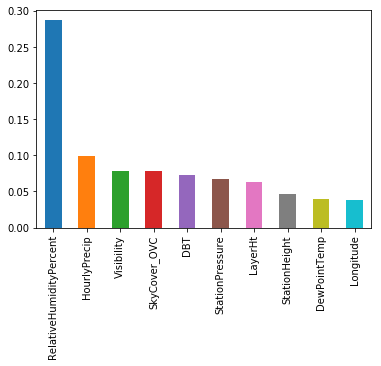

In [294]:
featimp = pd.Series(rfc.feature_importances_,index=usd_train.columns).sort_values(ascending=False)
featimp.nlargest(10).plot(kind='bar')

### 2. OverSampling the Data

In [125]:
data_train_X = X_dum
data_train_y = Y

In [126]:
data_train_X["FlightDelayStatus"]= data_train_y # combining class with original data
data_train = data_train_X.copy() # for naming conevntion
print("length of training data",len(data_train))
# Now make data set of normal transction from train data
delay_data = data_train[data_train["FlightDelayStatus"]==1]
print("length of delay data",len(delay_data))
nonDelay_data = data_train[data_train["FlightDelayStatus"]==2]
print("length of NOT delay data",len(nonDelay_data))

length of training data 7861
length of delay data 1519
length of NOT delay data 6342


In [127]:
for i in range (3): # the number is choosen by myself on basis of nnumber of fraud transaction
    nonDelay_data= nonDelay_data.append(delay_data)
os_data = nonDelay_data.copy() 
print("length of oversampled data is ",len(os_data))
print("Number of flights not delayed in oversampled data",len(os_data[os_data["FlightDelayStatus"]==2]))
print("No.of flights delayed",len(os_data[os_data["FlightDelayStatus"]==1]))
print("Proportion of flights delayed in oversampled data is ",len(os_data[os_data["FlightDelayStatus"]==1])/len(os_data))
print("Proportion of flights not delayed in oversampled data is ",len(os_data[os_data["FlightDelayStatus"]==2])/len(os_data))

length of oversampled data is  10899
Number of flights not delayed in oversampled data 6342
No.of flights delayed 4557
Proportion of flights delayed in oversampled data is  0.41811175337186895
Proportion of flights not delayed in oversampled data is  0.581888246628131


In [128]:
os_data.head()

,Distance,GroundHeight,StationHeight,BarometerHeight,Latitude,Longitude,Visibility,DBT,DewPointTemp,RelativeHumidityPercent,WindSpeed,WindGustValue,StationPressure,HourlyPrecip,LayerHt,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,...,SkyCover_CLR,SkyCover_FEW,SkyCover_OVC,SkyCover_SCT,WindCompDir_ENE,WindCompDir_ESE,WindCompDir_N,WindCompDir_NE,WindCompDir_NNE,WindCompDir_NNW,WindCompDir_NW,WindCompDir_S,WindCompDir_SE,WindCompDir_SSE,WindCompDir_SSW,WindCompDir_SW,WindCompDir_W,WindCompDir_WNW,WindCompDir_WSW,FlightDelayStatus
0,303,971,1026,974,33.38,-84.26,7.0,60.0,57.0,90.0,13,0.0,28.72,0.54,47,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
1,269,0,0,0,37.05,-113.35,10.0,81.0,30.0,16.0,8,0.0,29.84,0.00,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
2,282,559,596,562,32.54,-97.02,9.0,73.0,71.0,94.0,8,0.0,29.10,1.06,45,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
3,241,0,0,0,33.27,-88.35,10.0,72.0,70.0,93.0,3,0.0,30.16,0.00,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
4,130,0,848,0,31.05,-97.41,10.0,61.0,52.0,72.0,11,18.0,30.18,0.00,14,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2


#### Standardizing the oversampled data and dividing it into train and test split

In [258]:
os_data = os_data.reset_index(drop =True)
X_os = os_data.drop('FlightDelayStatus', axis = 1)
Y_os = os_data['FlightDelayStatus']

osd_scale = pd.DataFrame(preprocessing.scale(X_os[num_names]),columns = num_names)
osd_cat = X_os[cat_names]
standardized_osd = pd.concat([osd_scale,osd_cat], axis=1, sort=False)
print(standardized_osd.shape)

osd_train,osd_val,osd_train_labels,osd_val_labels = train_test_split(standardized_osd,Y_os, test_size = 0.3, random_state= 123,stratify=Y_os)
print(osd_train.shape)
print(osd_val.shape)
print(osd_train_labels.shape)
print(osd_val_labels.shape)

(10899, 40)
(7629, 40)
(3270, 40)
(7629,)
(3270,)


### Random Forest Classifier

In [295]:
rfc = RandomForestClassifier(n_estimators=2,max_depth = 20 ,min_samples_leaf= 24)
rfc.fit(osd_train,osd_train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=24, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [296]:
predtr8 = rfc.predict(osd_train)
predva8 = rfc.predict(osd_val)
predte8 = rfc.predict(x_test)
evaluation(predtr8,predva8,osd_train_labels,osd_val_labels)

Train Data :
Accuarcy 0.7434788307772972
Precision 0.7226435536294691
Recall    0.6272727272727273
F1_score  0.6715891928175868
Validation Data :
Accuarcy 0.7030581039755351
Precision 0.6666666666666666
Recall    0.5793708851499634
F1_score  0.6199608610567514


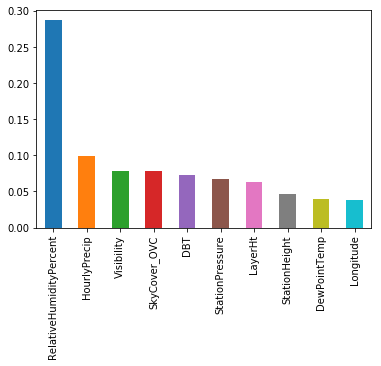

In [297]:
featimpos = pd.Series(rfc.feature_importances_,index=osd_train.columns).sort_values(ascending=False)
featimp.nlargest(10).plot(kind='bar')

### Logistic regression

In [298]:
lr = LogisticRegression()
lr.fit(osd_train,osd_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [299]:
predtr8l = lr.predict(osd_train)
predva8l = lr.predict(osd_val)
predte8l = lr.predict(x_test)
evaluation(predtr8l,predva8l,osd_train_labels,osd_val_labels)

Train Data :
Accuarcy 0.7003539127015336
Precision 0.6834415584415584
Recall    0.5278996865203762
F1_score  0.5956844711708524
Validation Data :
Accuarcy 0.6908256880733945
Precision 0.6692015209125475
Recall    0.514996342355523
F1_score  0.5820587019429516


### 3. SMOTE

In [138]:
os = SMOTE(random_state=0) #   We are using SMOTE as the function for oversampling
data_train_X = X_dum
data_train_y = Y
columns = data_train_X.columns

In [139]:
os_data_X,os_data_y=os.fit_sample(data_train_X,data_train_y)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=["FlightDelayStatus"])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of not dealyed flights in oversampled data",len(os_data_y[os_data_y["FlightDelayStatus"]==2]))
print("No.of delayed flights",len(os_data_y[os_data_y["FlightDelayStatus"]==1]))
print("Proportion of not delayed in oversampled data is ",len(os_data_y[os_data_y["FlightDelayStatus"]==2])/len(os_data_X))
print("Proportion of delayed flights in oversampled data is ",len(os_data_y[os_data_y["FlightDelayStatus"]==1])/len(os_data_X))

length of oversampled data is  12684
Number of not dealyed flights in oversampled data 6342
No.of delayed flights 6342
Proportion of not delayed in oversampled data is  0.5
Proportion of delayed flights in oversampled data is  0.5


In [140]:
os_scale = pd.DataFrame(preprocessing.scale(os_data_X[num_names]),columns = num_names)
os_cat = os_data_X[cat_names]
standardized_os = pd.concat([os_scale,os_cat], axis=1, sort=False)
print(standardized_os.shape)

os_train,os_val,os_train_labels,os_val_labels = train_test_split(standardized_os,os_data_y, test_size = 0.2, random_state= 123,stratify=os_data_y)
print(os_train.shape)
print(os_val.shape)
print(os_train_labels.shape)
print(os_val_labels.shape)


(12684, 40)
(10147, 40)
(2537, 40)
(10147, 1)
(2537, 1)


#### Random forest classifier 

In [302]:
rfc = RandomForestClassifier(n_estimators=5,max_depth = 7, min_samples_leaf = 5,class_weight='balanced')
rfc.fit(os_train,os_train_labels)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=7, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [303]:
predtr9 = rfc.predict(os_train)
predva9 = rfc.predict(os_val)
predte9 = rfc.predict(x_test)
evaluation(predtr9,predva9,os_train_labels,os_val_labels)

Train Data :
Accuarcy 0.8271410269045038
Precision 0.8545182653279214
Recall    0.7884880741178789
F1_score  0.8201763379126511
Validation Data :
Accuarcy 0.8037051635790303
Precision 0.8286445012787724
Recall    0.7659574468085106
F1_score  0.7960687960687961


#### Creating new features x,y,z cordinates from longitudes and latitudes and quarter from month column

In [223]:
DataV5 = DataV4
xcor = [0]*7861
ycor = [0]*7861
zcor = [0]*7861
DataV5.Latitude = DataV5.Latitude.astype("float64")
DataV5.Longitude = DataV5.Longitude.astype("float64")
for i in range(0, len(DataV5)):
    xcor[i] = math.cos(DataV5.Longitude[i]) * math.cos(DataV5.Latitude[i])
    ycor[i] = math.sin(DataV5.Longitude[i]) * math.cos(DataV5.Latitude[i])
    zcor[i] = math.sin(DataV5.Latitude[i])

In [224]:
DataV5['quarter'] = DataV3.ScheduledArrTimeStamp.dt.quarter

In [225]:
TestV6 = TestV5
txcor = [0]*7861
tycor = [0]*7861
tzcor = [0]*7861
TestV6.Latitude = TestV6.Latitude.astype("float64")
TestV6.Longitude = TestV6.Longitude.astype("float64")
for i in range(0, len(TestV6)):
    txcor[i] = math.cos(TestV6.Longitude[i]) * math.cos(TestV6.Latitude[i])
    tycor[i] = math.sin(TestV6.Longitude[i]) * math.cos(TestV6.Latitude[i])
    tzcor[i] = math.sin(TestV6.Latitude[i])

In [226]:
TestV6['quarter'] = TestV4.ScheduledArrTimeStamp.dt.quarter

In [227]:
DataV5['xcor'] = pd.DataFrame(xcor)
DataV5['ycor'] = pd.DataFrame(ycor)
DataV5['zcor'] = pd.DataFrame(zcor)
TestV6['xcor'] = pd.DataFrame(txcor)
TestV6['ycor'] = pd.DataFrame(tycor)
TestV6['zcor'] = pd.DataFrame(tzcor)

#### Since the importance is very low for WindCompDir dropping it and again adding the original column WindDirection

In [228]:
DataV5['WindDirection'] = 0
DataV5['WindDirection'] = DataV4.WindDirection
TestV6['WindDirection'] = 0
TestV6['WindDirection'] = TestV5.WindDirection

In [229]:
DataV5 = DataV5.drop(['Longitude','Latitude','WindCompDir'],axis = 1)
TestV6 = TestV6.drop(['Longitude','Latitude','WindCompDir'],axis = 1)

In [189]:
Xa = DataV5.drop('FlightDelayStatus',axis =1)
Ya = DataV5.FlightDelayStatus

#### Creating dummies and standardizing the data

In [230]:
X_dum1 = pd.get_dummies(Xa)

In [231]:
Test_dum1 = pd.get_dummies(TestV6)

In [232]:
num_names1 = ['Distance','xcor','ycor','zcor','GroundHeight','StationHeight','BarometerHeight','Visibility','DBT','DewPointTemp','RelativeHumidityPercent','WindSpeed','WindGustValue','StationPressure','HourlyPrecip','LayerHt','WindDirection']
cat_names1 = X_dum1[X_dum1.columns.difference(num_names1)].columns

#num_scale1 = pd.DataFrame(X_dum1[num_names1],columns = num_names1)
num_scale1 = pd.DataFrame(preprocessing.scale(X_dum1[num_names1]),columns = num_names1)
cat1 = X_dum1[cat_names1]
#test_num_scale1 = pd.DataFrame(Test_dum1[num_names1],columns = num_names1)
test_num_scale1 = pd.DataFrame(preprocessing.scale(Test_dum1[num_names1]),columns = num_names1)
test_cat1 = Test_dum1[cat_names1]
standardized_X1 = pd.concat([num_scale1,cat1], axis=1, sort=False)
print(standardized_X1.shape)
x_test1 = pd.concat([test_num_scale1,test_cat1], axis=1, sort=False)
print(x_test1.shape)

x_train1,x_val1,y_train1,y_val1 = train_test_split(standardized_X1,Ya, test_size = 0.2, random_state= 123,stratify=Ya)
print(x_train1.shape)
print(x_val1.shape)
print(y_train1.shape)
print(y_val1.shape)

(7861, 29)
(6566, 29)
(6288, 29)
(1573, 29)
(6288,)
(1573,)


###  Random Forest Classifier

In [304]:
rfc = RandomForestClassifier(n_estimators=10,max_depth = 10,min_samples_leaf=8)
rfc.fit(x_train1,y_train1)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [305]:
predtr10 = rfc.predict(x_train1)
predva10 = rfc.predict(x_val1)
predte10 = rfc.predict(x_test1)
evaluation(predtr10,predva10,y_train1,y_val1)

Train Data :
Accuarcy 0.8487595419847328
Precision 0.8367346938775511
Recall    0.26995884773662554
F1_score  0.4082140634723087
Validation Data :
Accuarcy 0.8207247298156389
Precision 0.6375
Recall    0.16776315789473684
F1_score  0.265625


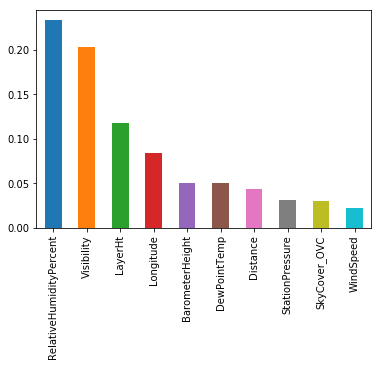

In [237]:
featimpos = pd.Series(rfc.feature_importances_,index=x_train1.columns).sort_values(ascending=False)
featimp.nlargest(10).plot(kind='bar')

### Model Performance:

#### Random forest model on oversampled data gave best performance when used with test data and also have less False Negatives in validation data. FN implies that we predicted there is no delay but actually delay is present. F1-Score on test data turned out to 35.


### Conclusion and summary :

#### On studying the Flight delay patterns using multiple techniques, I concluded that the following features play a major role in Flight Delay.

-  RelativeHumidityPercent
-  Hourly Precip 
-  Visibility 
-  SkyCover_OVC
-  DBT
-  StationPressure
-  LayerHt
-  StationHeight
-  DewPointTemp
-  Longitude

In [309]:
%%HTML
<div class='tableauPlaceholder' id='viz1551463073625' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;Book3_15514630607200&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Book3_15514630607200&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;Book3_15514630607200&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1551463073625');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.minWidth='420px';vizElement.style.maxWidth='450px';vizElement.style.width='100%';vizElement.style.height='487px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [306]:
%%HTML
<div class='tableauPlaceholder' id='viz1551458228848' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;vi&#47;viz_44&#47;Dashboard2&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='viz_44&#47;Dashboard2' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;vi&#47;viz_44&#47;Dashboard2&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1551458228848');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.minWidth='420px';vizElement.style.maxWidth='550px';vizElement.style.width='100%';vizElement.style.height='387px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [307]:
%%HTML
<div class='tableauPlaceholder' id='viz1551458378591' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;vi&#47;viz_44&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='viz_44&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;vi&#47;viz_44&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1551458378591');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.minWidth='420px';vizElement.style.maxWidth='1120px';vizElement.style.width='100%';vizElement.style.minHeight='367px';vizElement.style.maxHeight='487px';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [311]:
%%HTML
<div class='tableauPlaceholder' id='viz1551464422417' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;Book45_15514644115580&#47;Sheet1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Book45_15514644115580&#47;Sheet1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Bo&#47;Book45_15514644115580&#47;Sheet1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1551464422417');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

### Insights::
-  During the end of November most parts of the USA will be snowing, that may be the reason why no of flights delayed in November are more
-  More flights delayed when sky cover is over cast i.e with maximum cloud layer height
-  More flights are dealyed during evening around 4pm and 6pm
-  Provider must create new routes to reach destination that pass through airports with less flight delay rates
-  The no: of flights not delayed are more in airports where no of flights delayed are also more, implies that we should gradually reduce the no: flights from this airports and start rerouting to other airports where flights not dealyed are only more.